# Concurent topology and orientation optimization of a cantilever beam in 3D 
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/solid/topology+orientation.ipynb)

Concurrent topology and orientation optimization of a cantilever beam in 3D.

In [ ]:
import torch
from tqdm import tqdm
from scipy.optimize import bisect
import matplotlib.pyplot as plt

from torchfem import Solid
from torchfem.materials import TransverseIsotropicElasticity3D
from torchfem.mesh import cube_hexa
from torchfem.rotations import axis_rotation

torch.set_default_dtype(torch.float64)

## Model setup 
We start by defining the base problem without considering the optimization yet.

In [ ]:
# Material model
material = TransverseIsotropicElasticity3D(
    E_L=100.0, E_T=10.0, nu_L=0.3, nu_T=0.3, G_L=20.0
)
Nx = 20
Ny = 10
Nz = 15

# Create mesh
nodes, elements = cube_hexa(Nx + 1, Ny + 1, Nz + 1, Nx, Ny, Nz)

model = Solid(nodes, elements, material)

# Load at tip
tip = nodes[:, 0] == Nx
bottom = nodes[:, 2] == 0
model.forces[tip & bottom, 2] = -1.0
model.forces[tip & bottom & (nodes[:, 1] == 0), 2] = -0.5
model.forces[tip & bottom & (nodes[:, 1] == Ny), 2] = -0.5

# Constrained displacement at left end
model.constraints[nodes[:, 0] == 0.0, :] = True

# Solve
u, f, sigma, epsilon, state = model.solve()

# Plot
model.plot(u=u, node_property={"U": u})

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Optimization parameters 
We define the optimization parameters, i.e. the volume fraction, the penalization factor, the move limit, the filter radius, and the number of iterations.

In [3]:
volfrac = 0.3
p = 3
move = 0.2
R = 1.5
TORCH_SENS = False
ori_step = 10.0

In [4]:
# Initial, minimum, and maximum values of density
rho = volfrac * torch.ones(len(elements), requires_grad=True)
rho_min = 0.05 * torch.ones_like(rho)
rho_max = torch.ones_like(rho)

# Initial values of Euler angles
phi_x = torch.zeros(len(elements), requires_grad=True)
phi_y = torch.zeros(len(elements), requires_grad=True)
phi_z = torch.zeros(len(elements), requires_grad=True)

# Volume fraction
V_0 = volfrac * Nx * Ny * Nz

# Analytical gradient of the stiffness matrix
k0 = model.k0()
C0 = model.material.C.clone()

# Precompute filter weights
ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
dist = torch.cdist(ecenters, ecenters)
H = R - dist
H[dist > R] = 0.0

## Objective function

The objective function is the compliance of the structure. The compliance is defined as
$$
C = \frac{1}{2}\bm{u}^\top \bm{f}
$$
where $\bm{u}$ is the global displacement vector and $\bm{f}$ is the global force vector. 

The compliance is a measure of the energy stored in the structure due to the applied force and we want to minimize w.r.t. to the relative element densities $\bm{\rho}$ and the element-wise fiber orientations $\bm{\phi}$ in order to get a stiff structure.

In [5]:
def compliance(rho, phi_x, phi_y, phi_z):

    # Apply density
    model.material.C = torch.einsum("j,jkl->jkl", rho**p, C0)

    # Rotate
    rotation_z = axis_rotation(torch.tensor([0.0, 0.0, 1.0]), phi_z)
    rotation_y = axis_rotation(torch.tensor([0.0, 1.0, 0.0]), phi_y)
    rotation_x = axis_rotation(torch.tensor([1.0, 0.0, 0.0]), phi_x)
    rotation = rotation_x @ (rotation_y @ rotation_z)
    model.material.rotate(rotation)

    u, f, _, _, _ = model.solve()
    return 0.5 * torch.inner(u.ravel(), f.ravel())

## Filter

We employ a sensitivity filter for the relative densities to regularize the problem (mesh dependency) and to avoid checkerboard patterns. The filter is defined as
$$
\widetilde{\frac{\partial C}{\partial \rho_j}} = \frac{1}{\rho_j} \frac{\sum_i H_{ji} \rho_i \frac{\partial C}{\partial \rho_i} }{\sum_i H_{ji}}
$$
where $H_{ji}$ is the filter kernel. We use a simple linear filter kernel defined as 
$$
H_{ji} = \max(0, r - \lVert \bm{x}_i - \bm{x}_j \rVert)
$$
with element centers $\bm{x}_i$ and $\bm{x}_j$ and filter radius $r$.

In [6]:
filter_radius = 1.5
ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
dist = torch.cdist(ecenters, ecenters)
H = filter_radius - dist
H[dist > filter_radius] = 0.0

## Optimization with optimality constraints. 

This takes 5 minutes to run

In [7]:
def optimize(rho, phi_x, phi_y, phi_z, n_iter=100):
    # Bounds
    rho_min = 0.001 * torch.ones_like(rho)
    rho_max = torch.ones_like(rho)

    # Storage for compliance
    energies = []

    for _ in tqdm(range(n_iter)):
        C = compliance(rho, phi_x, phi_y, phi_z)
        dC_dphi_x = torch.autograd.grad(C, phi_x, retain_graph=True)[0]
        dC_dphi_y = torch.autograd.grad(C, phi_y, retain_graph=True)[0]
        dC_dphi_z = torch.autograd.grad(C, phi_z, retain_graph=True)[0]
        dC_drho = torch.autograd.grad(C, rho)[0]
        dC_drho = H @ (rho * dC_drho) / H.sum(dim=0) / rho

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -dC_drho / mu
            upper = torch.min(rho_max, (1 + move) * rho)
            lower = torch.max(rho_min, (1 - move) * rho)
            rho_trial = G_k**0.5 * rho
            return torch.max(torch.min(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return rho_k.sum() - V_0

        # Find the root of g(mu)
        with torch.no_grad():
            mu = bisect(g, 1e-10, 100.0)

        # Advance rho and phi
        rho.data = make_step(mu)
        phi_x.data -= ori_step * dC_dphi_x.data
        phi_y.data -= ori_step * dC_dphi_y.data
        phi_z.data -= ori_step * dC_dphi_z.data

        # Track compliance
        with torch.no_grad():
            energies.append(C.item())
    return energies

100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


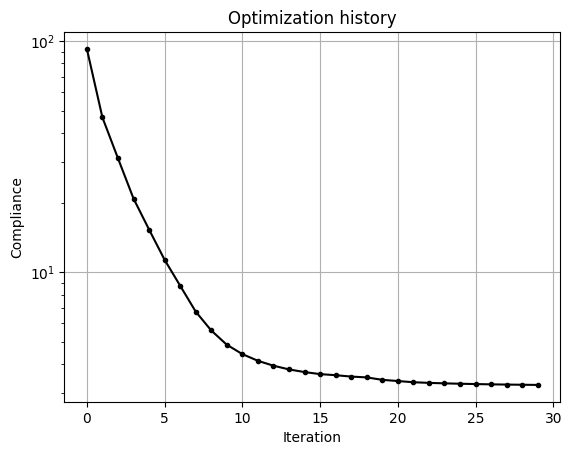

In [8]:
energies = optimize(rho, phi_x, phi_y, phi_z, 30)
plt.semilogy(energies, ".-k")
plt.grid()
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

# Make plots

In [9]:
# Rotate
rotation_z = axis_rotation(torch.tensor([0.0, 0.0, 1.0]), phi_z)
rotation_y = axis_rotation(torch.tensor([0.0, 1.0, 0.0]), phi_y)
rotation_x = axis_rotation(torch.tensor([1.0, 0.0, 0.0]), phi_x)
rotation = rotation_x @ (rotation_y @ rotation_z)
dir = torch.moveaxis(
    rotation @ torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]), 2, 1
)

model.plot(
    element_property={"rho": rho},
    cmap="gray_r",
    orientations=dir,
    opacity=0.2,
    threshold_condition=rho > 0.5,
)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [10]:
from torchfem.io import export_mesh

export_mesh(model, "result.vtu", elem_data={"rho": [rho]})